<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Hands-on/04-text-mining/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment analysis:

Looking at the ham/spam dataset, we don't have labels that say whether a message is positive or negative.  But we can check whether a message is more similar to a positive or a negative embedding.

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/elhamod/BA820/main/Hands-on/04-text-mining/movie.csv")

df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Inspect

Is the dataset balanced?

In [2]:
df["label"].value_counts()

0    20019
1    19981
Name: label, dtype: int64

Perhps, we look at the message length.

<Axes: >

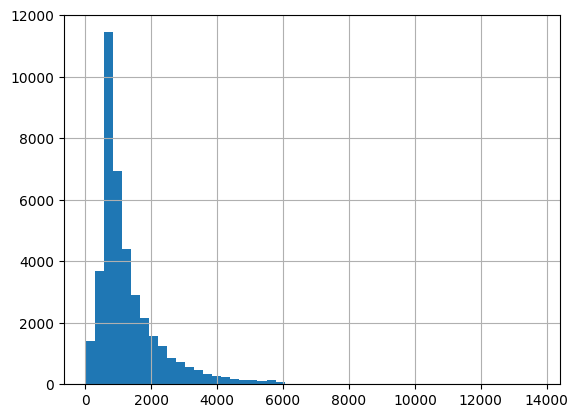

In [3]:
df["text"].apply(lambda x: len(x)).hist(bins=50)

Let's sample a subset.

In [4]:
df = df.sample(4000)

##pre-processing

Cleaning up and tokenizing...

In [5]:
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

df["text_prcessed"] = df["text"].str.lower()

df["text_prcessed"] = df["text_prcessed"].replace('<br />', ' ', regex=True)

df["text_prcessed"] = df["text_prcessed"].replace('[^\w\d\s]', ' ', regex=True)


tokenized_reviews = [word_tokenize(review) for review in df["text_prcessed"]]

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Remove stop words
for indx, tokens in enumerate(tokenized_reviews):
  tokenized_reviews[indx] = [word for word in tokens if word not in stop_words]


df["tokenized"] = tokenized_reviews

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
df.head()

,text,label,text_prcessed,tokenized
12157,I saw this 1997 movie because I am a fan of Lo...,1,i saw this 1997 movie because i am a fan of lo...,"[saw, 1997, movie, fan, lorenzo, lamas, father..."
33264,This is high grade cheese fare of B movie kung...,0,this is high grade cheese fare of b movie kung...,"[high, grade, cheese, fare, b, movie, kung, fu..."
14034,Miyazaki's Studio Ghibli shows his wonderful t...,1,miyazaki s studio ghibli shows his wonderful t...,"[miyazaki, studio, ghibli, shows, wonderful, t..."
37991,Seven young people go to the forest looking fo...,1,seven young people go to the forest looking fo...,"[seven, young, people, go, forest, looking, be..."
1631,I have watched every version of this play that...,1,i have watched every version of this play that...,"[watched, every, version, play, think, includi..."


##Vectorize

Build the word embedding model.

In [24]:
import gensim.downloader as api
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Either build your own model (pros and cons?)
# model_word2vec = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=2) # negative=50 , epochs=50, vector_size=300
# model_word2vec = model_word2vec.wv

# Or load a pre-trained model (pros and cons?)
# Load the Google News Word2Vec model
model_word2vec = api.load('glove-wiki-gigaword-50') # glove-wiki-gigaword-50 #word2vec-google-news-300

[==================================================] 100.0% 66.0/66.0MB downloaded


Get the word embeddings.

In [25]:
import nltk
nltk.download('punkt')

def get_word_embedding(word, model):
    if word in model.key_to_index:
        return model[word]
    else:
        return np.zeros(model.vector_size)


embeddings = []
for review in tokenized_reviews:
  review_embeddings = [get_word_embedding(word, model_word2vec) for word in review ]
  review_embedding = np.mean(review_embeddings if len(review_embeddings) >0 else [np.zeros(model_word2vec.vector_size)], axis=0)
  embeddings = embeddings + [review_embedding]

embeddings = np.array(embeddings)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
embeddings.shape

(4000, 50)

##Classify

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(embeddings, df['label'], test_size=0.2, random_state=42)

# train the model
model_word2vec_classification = LogisticRegression()
model_word2vec_classification.fit(X_train, y_train)

# Predict on the test data
y_pred2 = model_word2vec_classification.predict(X_test)

# Evaluate the model
f1_score = sklearn.metrics.f1_score(y_test, y_pred2)
print(f"f1_score: {f1_score}")
print(sklearn.metrics.classification_report(y_test,y_pred2))
pd.DataFrame(confusion_matrix(y_test, y_pred2, normalize='true'), columns=model_word2vec_classification.classes_, index=model_word2vec_classification.classes_ )

f1_score: 0.7405541561712846
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       400
           1       0.75      0.73      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800



,0,1
0,0.750,0.250
1,0.265,0.735


## Unsupervised approach

Let's construct two vectors, one is the ideal positive vector, and another is the ideal negatove one.

In [28]:
ideal_pos = ["fantastic", "love", "amazing", "nice", "beautiful", "like", "good"]
ideal_neg = ["boring", "terrible", "bad", "hate", "disappointed", "sucks"]

Let's test similarity with some review.

In [29]:
test_sentence = word_tokenize("I went to the movies. It was a really good one.") #df["tokenized"].iloc[4]

In [30]:
model_word2vec.n_similarity(test_sentence, ideal_pos)

0.8127746

In [31]:
model_word2vec.n_similarity(test_sentence, ideal_neg)

0.67270726

Let's apply this to all reviews

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized'], df['label'], test_size=0.2, random_state=42)

In [33]:
def sentiment(review):
  return model_word2vec.n_similarity(review, ideal_pos) - model_word2vec.n_similarity(review, ideal_neg)

In [34]:
sentiment_score_train = X_train.apply(lambda x: sentiment(x))

<Axes: >

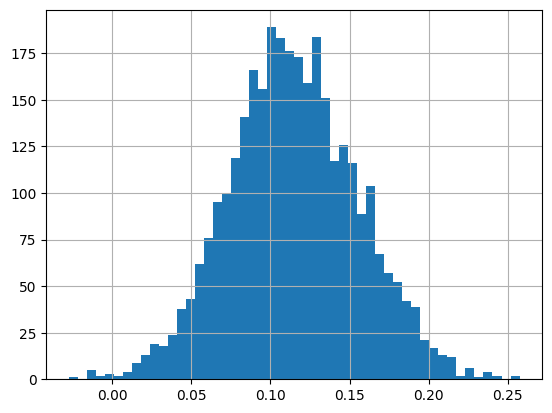

In [35]:
sentiment_score_train.hist(bins=50)

Let's take the mean as the splitting point between positive and negative sentiments.

In [36]:
train_mean = sentiment_score_train.mean()
train_mean

0.11477426

Let's test our theory on a test set.

In [37]:
y_pred = X_test.apply(lambda x: sentiment(x)) > train_mean

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred, normalize='true')

array([[0.6725, 0.3275],
       [0.3125, 0.6875]])

<Axes: >

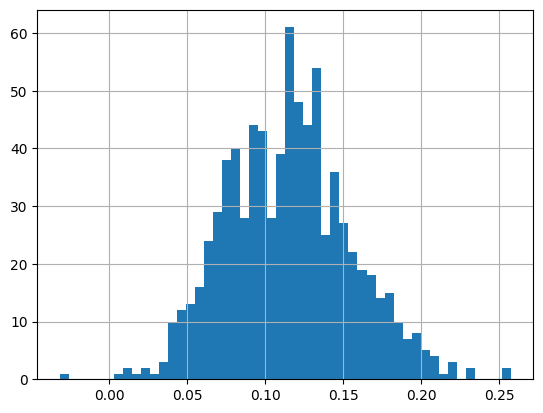

In [39]:
sentiment_score_test = X_test.apply(lambda x: sentiment(x))
sentiment_score_test.hist(bins=50)